##아이템 기반 협업 필터링 구현

협업 필터링의 경우, 추천 시스템 구현에서 많이 활용되는 것으로 알려져있다. 협업필터링은 아이템 기반과 사용자 기반으로 나누어진다. 아이템 기반은 유저수가 아이템보다 많은 경우에 주로 활용되고, 사용자 기반은 아이템 수가 유저수보다 많은 경우에 주로 활용된다.
- 아이템 기반 : A는 바나나, 사과, 우유, 치즈를 구매, B는 바나나, 우유 구매, C는 바나나 사과, 치즈를 구매했을 경우, B유저에게는 사과나 치즈를 추천해주고, C에게는 우유를 추천해주는 방식이다.(개인의 선호도도 반영하여 진행)
- 사용자 기반 : A와 B가 선호도가 유사한 경우, A가 구매한 내역 중, B가 구매하지 않은 상품을 B에게 추천해주는 방식이다. 
하지만, 아이템 기반 협업 필터링은 3가지의 단점이 있다.
그래서, 유저수가 아이템보다 많은 데이터를 다루었기 때문에 아이템 기반 협업 필터링을 진행하였다. 
1. 콜드 스타트: 콜드 스타트는 정보들의 양이 많이 적재되어 있지 않으면 정확도가 다소 낮다는 문제점이 있다. 그래서 대량의 데이터가 추구되어야 활용하기 좋은 방법이다. 현재, MSE 값이 좋게 나오지 않는 이유도 데이터 구매 내역이 많지 않아서, 일반화하기 어려운 점이 있는 것으로 추론한다.
2. 롱테일 문제: 롱테일 문제는 비챙직언 쏠림 현상을 말하는 것으로, 인기가 있는 제품(유명 브랜드)와 같은 제품만을 결국 추천해주게 된다는 것이다. 이러한 제품은 굳이 추천을 해주지 않아도 많은 유저들이 인지를 하고 있기 때문에 효율성이 떨어진다는 문제점이 있다.
3. 복잡한 계산량 : 협업 필터링 자체가, 비교적 많은 데이터를 다루어야 하기 때문에, 구현하기 위해선 복잡한 계산량을 가지게 된다.

#### 결론 : 아이템 기반 협업 핉터링의 문제점인 콜드 스타트와 복잡한 계산량을 해결해보고자 NLP와 결합한 추천 시스템을 구현해보겠다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action = 'ignore')
import os
import random

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

In [2]:
## train data, test data 호출
rec_df1 = pd.read_csv('/content/drive/MyDrive/Data/project_data/train_40k.csv')
rec_df2 = pd.read_csv('/content/drive/MyDrive/Data/project_data/val_10k.csv')

In [ ]:
rec_df1

,productId,Title,userId,Helpfulness,Score,Time,Text,Cat1,Cat2,Cat3
0,B000E46LYG,Golden Valley Natural Buffalo Jerky,A3MQDNGHDJU4MK,0/0,3.0,-1,The description and photo on this product need...,grocery gourmet food,meat poultry,jerky
1,B000GRA6N8,Westing Game,unknown,0/0,5.0,860630400,This was a great book!!!! It is well thought t...,toys games,games,unknown
2,B000GRA6N8,Westing Game,unknown,0/0,5.0,883008000,"I am a first year teacher, teaching 5th grade....",toys games,games,unknown
3,B000GRA6N8,Westing Game,unknown,0/0,5.0,897696000,I got the book at my bookfair at school lookin...,toys games,games,unknown
4,B00000DMDQ,I SPY A is For Jigsaw Puzzle 63pc,unknown,2/4,5.0,911865600,Hi! I'm Martine Redman and I created this puzz...,toys games,puzzles,jigsaw puzzles
...,...,...,...,...,...,...,...,...,...,...
39995,B0006IYND6,Japonesque Silver Lipstick Palette Kit 1 piece,A1WKFQYYRJ95F6,0/0,3.0,1344211200,Even when it is very convenient I find it real...,beauty,makeup,lips
39996,B000A33FZY,"Truform 20-30 Below Knee Closed-Toe, Beige, Small",A1OMZID10X2JY4,0/0,5.0,1344211200,Wore these the next day after eating Chinese t...,health personal care,medical supplies equipment,braces
39997,B000I7D2L4,Zadro Z300 Wall Mountable Fog Free Mirror,A3I8EYB4CKPQVO,0/0,3.0,1344211200,"this is an OK product. Doesn't really stay ""fo...",beauty,tools accessories,mirrors
39998,B000KHKKB2,Opalescent Glitter Lotion - 6.3 oz - Liquid,A3GTQQ5ZFCFBBL,0/0,4.0,1344211200,"This ""Glitter-Up"" body lotion offers tremendou...",beauty,skin care,body


In [ ]:
rec_df2

,productId,Title,userId,Helpfulness,Score,Time,Text,Cat1,Cat2,Cat3
0,B0002AQK70,PetSafe Staywell Pet Door with Clear Hard Flap,A2L6QTQQI13LZG,1/1,4.0,1344211200,We've only had it installed about 2 weeks. So ...,pet supplies,cats,cat flaps
1,B0002DK8OI,"Kaytee Timothy Cubes, 1-Pound",A2HJUOZ9R9K4F,0/0,1.0,1344211200,My bunny had a hard time eating this because t...,pet supplies,bunny rabbit central,food
2,B0006VJ6TO,Body Back Buddy,A14PK96LL78NN3,0/0,5.0,1344211200,would never in a million years have guessed th...,health personal care,health care,massage relaxation
3,B000EZSFXA,SnackMasters California Style Turkey Jerky,A2UW73HU9UMOTY,0/0,5.0,1344211200,"Being the jerky fanatic I am, snackmasters han...",grocery gourmet food,snack food,jerky dried meats
4,B000KV61FC,Premier Busy Buddy Tug-a-Jug Treat Dispensing ...,A1Q99RNV0TKW8R,1/1,4.0,1344211200,Wondered how quick my dog would catch on to th...,pet supplies,dogs,toys
...,...,...,...,...,...,...,...,...,...,...
9995,B000FGDDI0,Sunbeam 732-500 King Size Heating Pad with Ult...,A3RUBUKF0YX4C7,0/0,4.0,1362182400,Stays on continuously without shutting off! It...,health personal care,health care,pain relievers
9996,B000FVC78C,Reef One Biorb Easy Plants,A1O9H18FJG81FS,0/0,4.0,1362182400,these look great in our 10 gallon tank- colors...,pet supplies,fish aquatic pets,aquarium d cor
9997,B000ICJ8DA,Snoozer Lookout II Pet Car Seat,A3D96MTZP9C1Y,0/0,4.0,1362182400,"This works great, but needs a better way to at...",pet supplies,dogs,carriers travel products
9998,B000Q7AH3W,Omega Paw Tricky Treat Ball,A37L6DBOH234BC,0/0,5.0,1362182400,she absolutely LOVES this thing. I dice up gre...,pet supplies,dogs,toys


In [ ]:
rec_df1.info(),rec_df1.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   productId    40000 non-null  object 
 1   Title        39984 non-null  object 
 2   userId       40000 non-null  object 
 3   Helpfulness  40000 non-null  object 
 4   Score        40000 non-null  float64
 5   Time         40000 non-null  int64  
 6   Text         40000 non-null  object 
 7   Cat1         40000 non-null  object 
 8   Cat2         40000 non-null  object 
 9   Cat3         40000 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 3.1+ MB


(None, productId       0
 Title          16
 userId          0
 Helpfulness     0
 Score           0
 Time            0
 Text            0
 Cat1            0
 Cat2            0
 Cat3            0
 dtype: int64)

In [ ]:
rec_df2.info(),rec_df2.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   productId    10000 non-null  object 
 1   Title        9995 non-null   object 
 2   userId       10000 non-null  object 
 3   Helpfulness  10000 non-null  object 
 4   Score        10000 non-null  float64
 5   Time         10000 non-null  int64  
 6   Text         10000 non-null  object 
 7   Cat1         10000 non-null  object 
 8   Cat2         10000 non-null  object 
 9   Cat3         10000 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 781.4+ KB


(None, productId      0
 Title          5
 userId         0
 Helpfulness    0
 Score          0
 Time           0
 Text           0
 Cat1           0
 Cat2           0
 Cat3           0
 dtype: int64)

In [ ]:
## unknown이라는 유저 아이디가 기재되어 있지 않은 것을 발견할 수 있음.
rec_df1['userId']

0        A3MQDNGHDJU4MK
1               unknown
2               unknown
3               unknown
4               unknown
              ...      
39995    A1WKFQYYRJ95F6
39996    A1OMZID10X2JY4
39997    A3I8EYB4CKPQVO
39998    A3GTQQ5ZFCFBBL
39999    A3JXBFTAV1EZET
Name: userId, Length: 40000, dtype: object

In [ ]:
rec_df1 = rec_df1[rec_df1['userId'] != 'unknown'] #알 수 없는 정보 제거
rec_df2 = rec_df2[rec_df2['userId'] != 'unknown'] #알 수 없는 정보 제거

rec_df1 = rec_df1.drop(['Title', 'Helpfulness', 'Time', 'Cat3'], axis = 1) #불필요한 Feature 제거
rec_df2 = rec_df2.drop(['Title', 'Helpfulness', 'Time', 'Cat3'], axis = 1) #불필요한 Feature 제거

rec_df = pd.concat([rec_df1, rec_df2]).reset_index(drop = True)
rec_df

,productId,userId,Score,Text,Cat1,Cat2
0,B000E46LYG,A3MQDNGHDJU4MK,3.0,The description and photo on this product need...,grocery gourmet food,meat poultry
1,B00000JHQ0,AL91D1BD8J3WG,5.0,I've used these batteries my entire life in ev...,health personal care,household supplies
2,B00000IWGB,A2AXQTB83VMK4L,4.0,It's easy enough to learn and get into to. If ...,toys games,games
3,B00004CI84,A1048CYU0OV4O8,5.0,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,grocery gourmet food,beverages
4,B0000017QZ,A2VEX3YDK12LWE,5.0,this is one ofthe best i have ever heard for n...,health personal care,health care
...,...,...,...,...,...,...
48041,B000FGDDI0,A3RUBUKF0YX4C7,4.0,Stays on continuously without shutting off! It...,health personal care,health care
48042,B000FVC78C,A1O9H18FJG81FS,4.0,these look great in our 10 gallon tank- colors...,pet supplies,fish aquatic pets
48043,B000ICJ8DA,A3D96MTZP9C1Y,4.0,"This works great, but needs a better way to at...",pet supplies,dogs
48044,B000Q7AH3W,A37L6DBOH234BC,5.0,she absolutely LOVES this thing. I dice up gre...,pet supplies,dogs


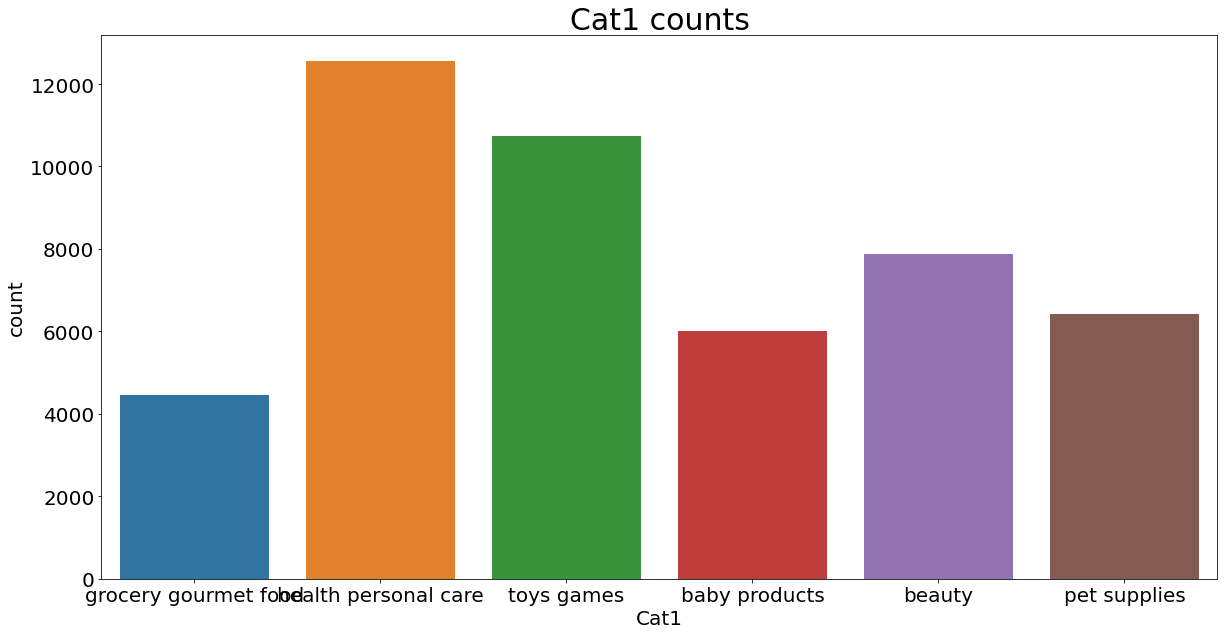

In [ ]:
plt.figure(figsize = (20, 10))
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('', fontsize = 20)
plt.ylabel('', fontsize = 20)
plt.title('Cat1 counts', fontsize= 30)
sns.countplot(rec_df['Cat1'])

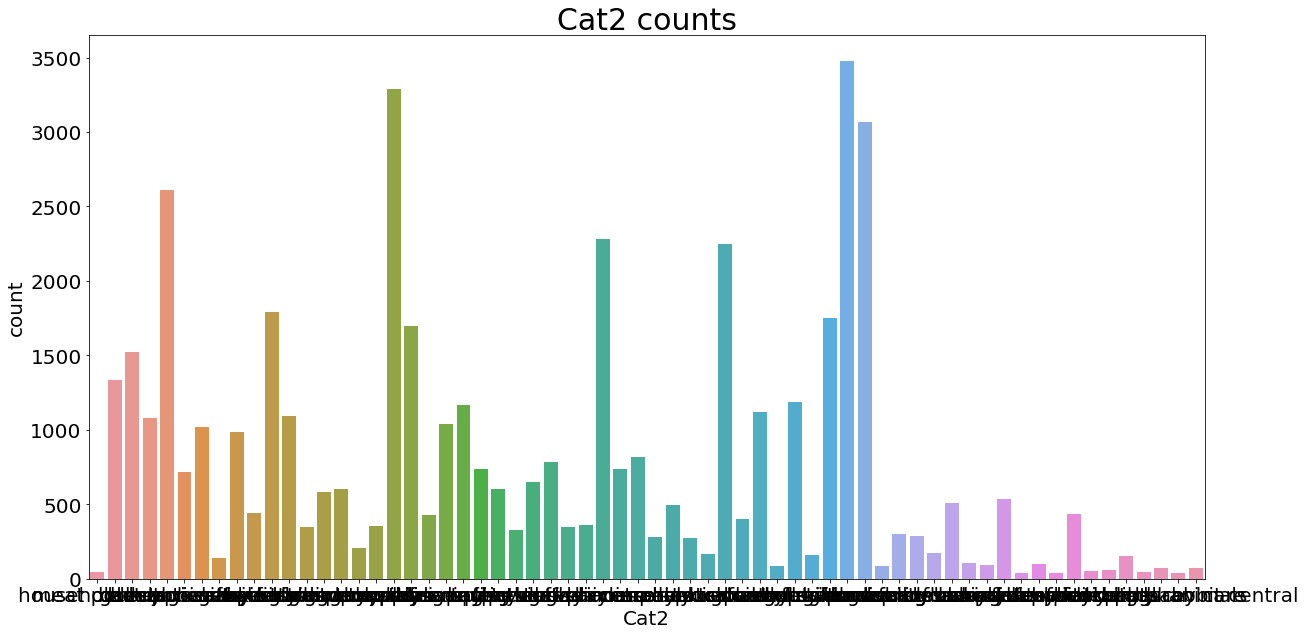

In [ ]:
plt.figure(figsize = (20, 10))
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('', fontsize = 20)
plt.ylabel('', fontsize = 20)
plt.title('Cat2 counts', fontsize= 30)
sns.countplot(rec_df['Cat2'])

In [ ]:
## 협업 필터링에 필요한 feature 추출
rec = rec_df[['productId', 'userId', 'Score']]
rec

,productId,userId,Score
0,B000E46LYG,A3MQDNGHDJU4MK,3.0
1,B00000JHQ0,AL91D1BD8J3WG,5.0
2,B00000IWGB,A2AXQTB83VMK4L,4.0
3,B00004CI84,A1048CYU0OV4O8,5.0
4,B0000017QZ,A2VEX3YDK12LWE,5.0
...,...,...,...
48041,B000FGDDI0,A3RUBUKF0YX4C7,4.0
48042,B000FVC78C,A1O9H18FJG81FS,4.0
48043,B000ICJ8DA,A3D96MTZP9C1Y,4.0
48044,B000Q7AH3W,A37L6DBOH234BC,5.0


In [ ]:
print('구매 내역이 있는 유저 수', len(rec['userId'].value_counts()))
print('구매 내역이 있는 아이템 수', len(rec['productId'].value_counts()))

구매 내역이 있는 유저 수 45837
구매 내역이 있는 아이템 수 23620


In [ ]:
rec1 = pd.DataFrame(rec['userId'].value_counts())
rec1 = rec1[rec1['userId'] > 2] ## 3개 이상 구매한 user
rec1

,userId
A3M174IC0VXOS2,25
A281NPSIMI1C2R,22
A1Z54EM24Y40LL,19
A1W9JOFE6F89FB,17
AJGU56YG8G1DQ,16
...,...
A1JA99OS0ISEBB,3
A2UQIIJ2CD8REE,3
AZTY4WBRB5MAL,3
A3NHUQ33CFH3VM,3


In [ ]:
rec1 = rec1.reset_index()
rec1 = rec1.rename(columns = {'index' : 'userId', 'userId' : 'number'})
rec1

,userId,number
0,A3M174IC0VXOS2,25
1,A281NPSIMI1C2R,22
2,A1Z54EM24Y40LL,19
3,A1W9JOFE6F89FB,17
4,AJGU56YG8G1DQ,16
...,...,...
252,A1JA99OS0ISEBB,3
253,A2UQIIJ2CD8REE,3
254,AZTY4WBRB5MAL,3
255,A3NHUQ33CFH3VM,3


In [ ]:
rec_data = pd.merge(rec, rec1, how = 'inner', on = 'userId')
rec_data = pd.pivot_table(rec_data, index = 'productId',
                     columns = 'userId',
                     values = 'Score').fillna(0) ## userId, productId pivot_table 만든 후, 구매 내역이 없는 결측치는 0으로 대체

rec_data

userId,A100CCQTI86IPF,A10Y1P3KSGN1UZ,A1115ST6F5CWYP,A11FX8HL2ANK6T,A11U94TLJYIYG0,A124H16ETAAGX6,A12AMBZJTC6MEB,A12C0UER29529W,A12ENBT314RFXR,A12M48NCU6GURO,A12PH6L5QSVTYN,A132ETQPMHQ585,A1335269OYXNPS,A13STKDYQO5DQ8,A13TO1ZFAH9SVN,A13TUGAAI1Y63A,A1409DK7GDFUXJ,A152I1BISLYNP9,A168O2YKPE9BE8,A17BUXSHOUOP4M,A17VIBT0O9LTPO,A17ZMCYTC61SVI,A19123D9G66E0O,A1A2QBFLIR5HCW,A1AP2LU7JGX6DE,A1BOJ3936IE1E0,A1C4J5MRES1KRK,A1CNVVEEJ8Q1ZR,A1CQON0P01BITL,A1CTEYY9TBS6W9,A1DTOHMM2Y5KY0,A1EUI1WWQJMXWT,A1EVV74UQYVKRY,A1FKQJ72DAP644,A1FXY0GUFHEI59,A1G6TJTVNUPYLU,A1HRYC60VTMYC0,A1IL6W1NK05UW9,A1JA99OS0ISEBB,A1JDILIHGMEPRI,...,AILM3RA8U0TND,AJB6NXJLATQLT,AJGU56YG8G1DQ,AJQDIT55SZ3ZX,AJZ9FMZC30EM5,AK0CENM3LUM28,AK7CAW3N1XZV6,AKCZIJ6ZHE41D,AKMEY1BSHSDG7,AKPJQZABVLRFR,AL0I8X5J1KBDB,AL6633WIKI7WE,ALDAF4VVLFRHP,ALLHJD3KZF9KC,AMPGRXQMO89X9,ANCLGWLDG6JUJ,APJINYKYAEJJ0,APLVNKSVKSYI1,APRB0DGZNQKK0,AQ8DU6XVA3USJ,AQZH7YTWQPOBE,ARSNOEEHHBKTK,AS3UM0LHN7L1Y,AS6SH2JM2YY3H,ATK1RL71E7AHC,ATUXNR3WHD18N,AW7FYP6TBY4AY,AW8EWPR4BBJQW,AWLK6NSSV0YNA,AXO4PQU0XG3TG,AXVKMYWNIHK7W,AY388IC4HD3VL,AYB4ELCS5AM8P,AYKG9PJK91VG1,AYWLGJPC5O7AQ,AZ31S5ACWRY15,AZ4IFJ01WKBTB,AZF13R8HNB59E,AZK9CCTYQNRNL,AZTY4WBRB5MAL
productId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
B00000DMBB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00000DMBK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00000IT0W,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00000IUXC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00000IW2S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B000QX50JC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B000R1XJ46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B000RZNJII,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [ ]:
rec_data.isnull().sum() # 결측치 확인

userId
A100CCQTI86IPF    0
A10Y1P3KSGN1UZ    0
A1115ST6F5CWYP    0
A11FX8HL2ANK6T    0
A11U94TLJYIYG0    0
                 ..
AZ31S5ACWRY15     0
AZ4IFJ01WKBTB     0
AZF13R8HNB59E     0
AZK9CCTYQNRNL     0
AZTY4WBRB5MAL     0
Length: 257, dtype: int64

In [ ]:
rec_data_t = rec_data.transpose() #pivot_table 전치
rec_data_t

productId,B00000DMBB,B00000DMBK,B00000IT0W,B00000IUXC,B00000IW2S,B00000IWCY,B00000IWD0,B00000IWD2,B00000IWD4,B00000IWI1,B00000IZJB,B00000IZOR,B00000IZPU,B00000J0HG,B00000J0S3,B00000J4SP,B00000JW9S,B00001P4WT,B00001P50I,B0000205XH,B00003TL7P,B00004D3ES,B00004T71M,B00004TH2M,B00004TUBV,B00004U9UY,B00004UD77,B00004UE4F,B00004UE4G,B00004UFOO,B00004UFOQ,B00004WHR4,B000050B6Z,B000050FDE,B000050FDX,B000052X9K,B000052XVB,B000052YDR,B000052YM7,B00005302V,...,B000PBX3GC,B000PC4ZCC,B000PDHGX6,B000PE9ILI,B000PELQ8Q,B000PESHFQ,B000PHZ134,B000PIMO2O,B000PK4OO8,B000PKC152,B000PKYSEO,B000PNTQW0,B000PSPNEA,B000PU31MY,B000PUKWOO,B000PXXI4M,B000Q29RHY,B000Q463QA,B000Q5X7PO,B000Q6BFXE,B000Q6ECIO,B000Q6EDBK,B000Q6EE2S,B000Q6EPF4,B000Q6I4XI,B000Q6I5TQ,B000Q6I9UG,B000Q6QU02,B000Q6SIAC,B000Q6V1UG,B000Q7AH3W,B000Q9FIPW,B000QF7L3I,B000QFRJSA,B000QFSOES,B000QX50JC,B000R1XJ46,B000RZNJII,B000TKPDJY,B000UICQZO
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A100CCQTI86IPF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10Y1P3KSGN1UZ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1115ST6F5CWYP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A11FX8HL2ANK6T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A11U94TLJYIYG0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZ31S5ACWRY15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZ4IFJ01WKBTB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZF13R8HNB59E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [ ]:
def cosine_rate(data, data_t):

    item_sim = cosine_similarity(data, data)

    item_sim_df = pd.DataFrame(item_sim, index = data_t.columns, columns = data_t.columns)

    return item_sim_df

In [ ]:
cs = cosine_rate(rec_data, rec_data_t) # 제품과 제품의 코사인 유사도 
cs

productId,B00000DMBB,B00000DMBK,B00000IT0W,B00000IUXC,B00000IW2S,B00000IWCY,B00000IWD0,B00000IWD2,B00000IWD4,B00000IWI1,B00000IZJB,B00000IZOR,B00000IZPU,B00000J0HG,B00000J0S3,B00000J4SP,B00000JW9S,B00001P4WT,B00001P50I,B0000205XH,B00003TL7P,B00004D3ES,B00004T71M,B00004TH2M,B00004TUBV,B00004U9UY,B00004UD77,B00004UE4F,B00004UE4G,B00004UFOO,B00004UFOQ,B00004WHR4,B000050B6Z,B000050FDE,B000050FDX,B000052X9K,B000052XVB,B000052YDR,B000052YM7,B00005302V,...,B000PBX3GC,B000PC4ZCC,B000PDHGX6,B000PE9ILI,B000PELQ8Q,B000PESHFQ,B000PHZ134,B000PIMO2O,B000PK4OO8,B000PKC152,B000PKYSEO,B000PNTQW0,B000PSPNEA,B000PU31MY,B000PUKWOO,B000PXXI4M,B000Q29RHY,B000Q463QA,B000Q5X7PO,B000Q6BFXE,B000Q6ECIO,B000Q6EDBK,B000Q6EE2S,B000Q6EPF4,B000Q6I4XI,B000Q6I5TQ,B000Q6I9UG,B000Q6QU02,B000Q6SIAC,B000Q6V1UG,B000Q7AH3W,B000Q9FIPW,B000QF7L3I,B000QFRJSA,B000QFSOES,B000QX50JC,B000R1XJ46,B000RZNJII,B000TKPDJY,B000UICQZO
productId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
B00000DMBB,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00000DMBK,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
B00000IT0W,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00000IUXC,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00000IW2S,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B000QX50JC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
B000R1XJ46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
B000RZNJII,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
def predict_rating(values, cosine):
    ratings_pred = values.dot(cosine) / np.array([np.abs(cosine).sum(axis = 1)])

    return ratings_pred

In [ ]:
ratings_pred = predict_rating(rec_data_t, cs)

ratings_pred

productId,B00000DMBB,B00000DMBK,B00000IT0W,B00000IUXC,B00000IW2S,B00000IWCY,B00000IWD0,B00000IWD2,B00000IWD4,B00000IWI1,B00000IZJB,B00000IZOR,B00000IZPU,B00000J0HG,B00000J0S3,B00000J4SP,B00000JW9S,B00001P4WT,B00001P50I,B0000205XH,B00003TL7P,B00004D3ES,B00004T71M,B00004TH2M,B00004TUBV,B00004U9UY,B00004UD77,B00004UE4F,B00004UE4G,B00004UFOO,B00004UFOQ,B00004WHR4,B000050B6Z,B000050FDE,B000050FDX,B000052X9K,B000052XVB,B000052YDR,B000052YM7,B00005302V,...,B000PBX3GC,B000PC4ZCC,B000PDHGX6,B000PE9ILI,B000PELQ8Q,B000PESHFQ,B000PHZ134,B000PIMO2O,B000PK4OO8,B000PKC152,B000PKYSEO,B000PNTQW0,B000PSPNEA,B000PU31MY,B000PUKWOO,B000PXXI4M,B000Q29RHY,B000Q463QA,B000Q5X7PO,B000Q6BFXE,B000Q6ECIO,B000Q6EDBK,B000Q6EE2S,B000Q6EPF4,B000Q6I4XI,B000Q6I5TQ,B000Q6I9UG,B000Q6QU02,B000Q6SIAC,B000Q6V1UG,B000Q7AH3W,B000Q9FIPW,B000QF7L3I,B000QFRJSA,B000QFSOES,B000QX50JC,B000R1XJ46,B000RZNJII,B000TKPDJY,B000UICQZO
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A100CCQTI86IPF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10Y1P3KSGN1UZ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1115ST6F5CWYP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A11FX8HL2ANK6T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A11U94TLJYIYG0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZ31S5ACWRY15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZ4IFJ01WKBTB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZF13R8HNB59E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [ ]:
def get_mse(pred, actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()

    return mean_squared_error(pred, actual)

In [ ]:
print('아이템 기반 모든 최근접 이웃 MSE:', get_mse(ratings_pred.values, rec_data_t.values))
## 생각보다 mse가 높은 것으로 확인됨..

아이템 기반 모든 최근접 이웃 MSE: 1.2128110494021875


In [ ]:
user = []
for i in rec_data_t.index:
    user.append(i)

In [ ]:
example = random.sample(user, 5) #랜덤으로 5명의 유저 추출
example 

['A2U3KT37A44NBM',
 'ARSNOEEHHBKTK',
 'A6LUXI8I8BU6P',
 'A1EUI1WWQJMXWT',
 'A12PH6L5QSVTYN']

In [ ]:
##유저들이 구매했던(리뷰 등록) 제품들 나열

for i in example :
    user_rating_id = rec_data_t.loc[i, :]
    print('----유저: ', i, '추출 ----')
    print(user_rating_id[user_rating_id > 0].sort_values(ascending=False)[:10])

----유저:  A2U3KT37A44NBM 추출 ----
productId
B0007WWZIQ    5.0
B000284X58    4.0
B000EQGSWE    3.0
Name: A2U3KT37A44NBM, dtype: float64
----유저:  ARSNOEEHHBKTK 추출 ----
productId
B000P9VNWU    5.0
B000P9XMXS    3.0
B000P9VO0G    3.0
Name: ARSNOEEHHBKTK, dtype: float64
----유저:  A6LUXI8I8BU6P 추출 ----
productId
B00085EWLA    4.0
B000PC4ZCC    3.0
B00085EWH4    3.0
Name: A6LUXI8I8BU6P, dtype: float64
----유저:  A1EUI1WWQJMXWT 추출 ----
productId
B000FJ9QTW    5.0
B0002CKGZK    5.0
B0002ASHIK    1.0
Name: A1EUI1WWQJMXWT, dtype: float64
----유저:  A12PH6L5QSVTYN 추출 ----
productId
B00021CV0Y    5.0
B00021CUFA    5.0
B0000533G8    5.0
Name: A12PH6L5QSVTYN, dtype: float64


In [ ]:
def get_not_tried_product(rec_data_t, userId):
    user_rating = rec_data_t.loc[userId, :]
    tried = user_rating[user_rating > 0].index.tolist()

    product_list = rec_data_t.columns.tolist()

    not_tried = [product for product in product_list if product not in tried]

    return not_tried, tried
## 0점이 넘는 제품은, 구매 내역이 있는 제품이고 0이 넘지 않는 제품은 구매한적이 없는 경우를 둘로 나눔.

In [ ]:
def recomm_product_by_userid(a, userId, not_tired, top_n):
    rec_product = a.loc[userId, not_tried].sort_values(ascending = False)[:top_n]

    return rec_product
## 구매하지 않은 제품 중, 평점을 정렬하여 상위 n개 제품 추천

In [ ]:
not_tried = get_not_tried_product(rec_data_t, example[0])[0]
tried = get_not_tried_product(rec_data_t, example[0])[1]
not_tried

['B00000DMBB',
 'B00000DMBK',
 'B00000IT0W',
 'B00000IUXC',
 'B00000IW2S',
 'B00000IWCY',
 'B00000IWD0',
 'B00000IWD2',
 'B00000IWD4',
 'B00000IWI1',
 'B00000IZJB',
 'B00000IZOR',
 'B00000IZPU',
 'B00000J0HG',
 'B00000J0S3',
 'B00000J4SP',
 'B00000JW9S',
 'B00001P4WT',
 'B00001P50I',
 'B0000205XH',
 'B00003TL7P',
 'B00004D3ES',
 'B00004T71M',
 'B00004TH2M',
 'B00004TUBV',
 'B00004U9UY',
 'B00004UD77',
 'B00004UE4F',
 'B00004UE4G',
 'B00004UFOO',
 'B00004UFOQ',
 'B00004WHR4',
 'B000050B6Z',
 'B000050FDE',
 'B000050FDX',
 'B000052X9K',
 'B000052XVB',
 'B000052YDR',
 'B000052YM7',
 'B00005302V',
 'B000053049',
 'B0000530IQ',
 'B0000531EN',
 'B0000531W1',
 'B00005324F',
 'B00005324K',
 'B0000532YP',
 'B00005334Z',
 'B0000533G8',
 'B0000535OF',
 'B0000537IO',
 'B000056J7L',
 'B000056J8B',
 'B000056JAZ',
 'B000056NTG',
 'B000056OV0',
 'B00005BHK9',
 'B00005BHPC',
 'B00005BL26',
 'B00005BZKD',
 'B00005JIVI',
 'B00005JSB6',
 'B00005KBVD',
 'B00005M1WE',
 'B00005MA07',
 'B00005N9EE',
 'B00005NF

In [ ]:
## 상위 5개 제품 추천(랜덤으로 추출한 유저 0번째 고객에 대한 추출)
rec_product = recomm_product_by_userid(ratings_pred, example[0], not_tried, 5)
rec_product = pd.DataFrame(data = rec_product.values, index = rec_product.index,
                           columns = ['예측평점'])

rec_product = rec_product.reset_index()
rec_product

,productId,예측평점
0,B000ETREQA,0.653328
1,B000CSWM9C,0.653328
2,B000F1QKRQ,0.653328
3,B000F9XB5C,0.653328
4,B00020HHAO,0.000000


In [ ]:
information = rec_df[['productId', 'Cat1', 'Cat2', 'Score']] 
information['mean_score'] = information['Score']
information['mean_score']

0        3.0
1        5.0
2        4.0
3        5.0
4        5.0
        ... 
48041    4.0
48042    4.0
48043    4.0
48044    5.0
48045    5.0
Name: mean_score, Length: 48046, dtype: float64

In [ ]:
pd.merge(rec_product, information, how = 'inner', on = 'productId')

,productId,예측평점,Cat1,Cat2,Score,mean_score
0,B000ETREQA,0.653328,toys games,electronics for kids,5.0,5.0
1,B000ETREQA,0.653328,toys games,electronics for kids,5.0,5.0
2,B000ETREQA,0.653328,toys games,electronics for kids,2.0,2.0
3,B000ETREQA,0.653328,toys games,electronics for kids,4.0,4.0
4,B000ETREQA,0.653328,toys games,electronics for kids,5.0,5.0
5,B000CSWM9C,0.653328,beauty,skin care,1.0,1.0
6,B000CSWM9C,0.653328,beauty,skin care,5.0,5.0
7,B000F1QKRQ,0.653328,baby products,potty training,5.0,5.0
8,B000F1QKRQ,0.653328,baby products,potty training,5.0,5.0
9,B000F1QKRQ,0.653328,baby products,potty training,5.0,5.0


In [ ]:
pro_score = pd.DataFrame(information.groupby('productId').Score.mean())
pro_score = pro_score.reset_index()
pro_score

,productId,Score
0,B0000017QN,4.000000
1,B0000017QZ,5.000000
2,B00000DMBB,4.666667
3,B00000DMBD,5.000000
4,B00000DMBF,4.000000
...,...,...
23615,B000UYC9SW,4.285714
23616,B000V35FGA,4.000000
23617,B000V521PQ,5.000000
23618,B000V5BXP0,5.000000


In [ ]:
## 추천되는 제품에 대한 정보까지 추출 진행
information = pd.merge(pro_score, information[['productId', 'Cat1', 'Cat2']], how = 'left', on = 'productId')
information = information.drop_duplicates()
information 

,productId,Score,Cat1,Cat2
0,B0000017QN,4.000000,health personal care,health care
1,B0000017QZ,5.000000,health personal care,health care
2,B00000DMBB,4.666667,toys games,games
5,B00000DMBD,5.000000,toys games,games
9,B00000DMBF,4.000000,toys games,games
...,...,...,...,...
48034,B000UYC9SW,4.285714,baby products,gear
48041,B000V35FGA,4.000000,beauty,makeup
48043,B000V521PQ,5.000000,beauty,skin care
48044,B000V5BXP0,5.000000,beauty,makeup


In [ ]:
def rec_product_list(rec_product, name):
    print(name,'유저의 제품 추천 목록')
    rec = pd.merge(rec_product, information, how = 'inner', on = 'productId')
    # rec = rec.drop('예측평점', axis = 1)

    return rec


def tried_product_list(tried):
    for i in tried:
        print(information[information['productId'] == i])

In [ ]:
rec_product_list(rec_product, example[0])

A2U3KT37A44NBM 유저의 제품 추천 목록


,productId,예측평점,Score,Cat1,Cat2
0,B000ETREQA,0.653328,4.2,toys games,electronics for kids
1,B000CSWM9C,0.653328,3.0,beauty,skin care
2,B000F1QKRQ,0.653328,4.5,baby products,potty training
3,B000F9XB5C,0.653328,3.0,grocery gourmet food,breads bakery
4,B00020HHAO,0.000000,3.5,health personal care,nutrition wellness


In [ ]:
tried_product_list(tried)

        productId     Score        Cat1                  Cat2
12807  B000284X58  3.076923  toys games  electronics for kids
        productId  Score        Cat1                  Cat2
20853  B0007WWZIQ    3.8  toys games  electronics for kids
        productId  Score        Cat1           Cat2
30301  B000EQGSWE    3.0  toys games  building toys


### NLP를 통한 카테고리 예측 후, 예측된 카테고리에 따라 제품 추천 

검색어를 통한 카테고리 예측 후, 카테고리에 맞는 높은 평점 Top 5 제품 추천

단순히 평균 평점이 높은 제품을 추천해주기엔 불안정한 경우의 수들이 있다.
예를 들자면, 1명이 구매한 A라는 제품의 평점이 5점이고, 100명이 주문한 B 제품의 평균 평점이 4.5라면 상대적으로 많은 소비자들이 B 제품 구매 관여도가 낮을 것이다. 반면에, 1명의 평균 평점이 5점이있던 제품은 1명의 평점만 있기 때문에 오히려 제품 구매에 많이 망설이게 될 것이다.
그러므로, 평점이 총 10점이라는 새로운 평점 계산을 만들 것이다. 기본적인 평균 평점이 5점 만점으로 두고, 나머지 평균 평점 x (제품 구매의 총 수 / 전체 구매 수)를 가중치로 더한 값으로 평점을 재조정하여, 높은 순서대로 추출을 할 것이다.

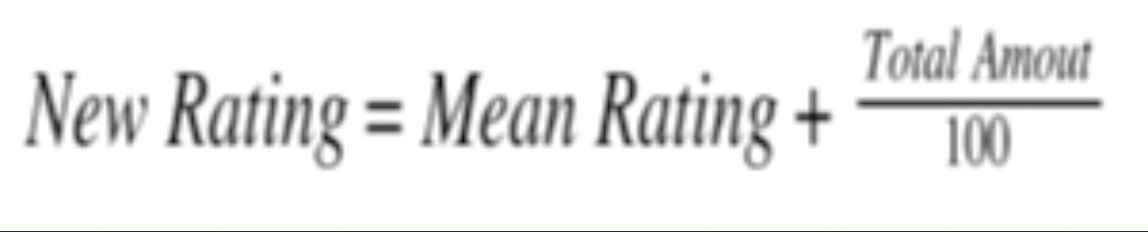

-Mean Rating : 제품별 평균 평점
-Total Amount : 제품별 총 누적 판매량

In [3]:
## train data, test data 재호출
rec_df1 = pd.read_csv('/content/drive/MyDrive/Data/project_data/train_40k.csv')
rec_df2 = pd.read_csv('/content/drive/MyDrive/Data/project_data/val_10k.csv')

In [4]:
train1 = pd.concat([rec_df1, rec_df2]).reset_index(drop = True)

In [5]:
rating_rec = pd.concat([rec_df1, rec_df2]).reset_index(drop = True)[['productId', 'Score', 'Cat1', 'Cat2']]
rating_rec

,productId,Score,Cat1,Cat2
0,B000E46LYG,3.0,grocery gourmet food,meat poultry
1,B000GRA6N8,5.0,toys games,games
2,B000GRA6N8,5.0,toys games,games
3,B000GRA6N8,5.0,toys games,games
4,B00000DMDQ,5.0,toys games,puzzles
...,...,...,...,...
49995,B000FGDDI0,4.0,health personal care,health care
49996,B000FVC78C,4.0,pet supplies,fish aquatic pets
49997,B000ICJ8DA,4.0,pet supplies,dogs
49998,B000Q7AH3W,5.0,pet supplies,dogs


In [6]:
mean_rating = pd.DataFrame(rating_rec.groupby('productId').Score.mean())
mean_rating = mean_rating.reset_index()
mean_rating

,productId,Score
0,B0000017QN,4.000000
1,B0000017QZ,5.000000
2,B00000DMBB,4.750000
3,B00000DMBD,5.000000
4,B00000DMBE,5.000000
...,...,...
24378,B000UYC9SW,4.285714
24379,B000V35FGA,4.000000
24380,B000V521PQ,5.000000
24381,B000V5BXP0,5.000000


In [7]:
total_buying = pd.DataFrame(rating_rec['productId'].value_counts()).reset_index()
total_buying = total_buying.rename(columns = {'index':'productId', 'productId':'total'})
total_buying

,productId,total
0,B000FSFNUE,159
1,B000GLRREU,113
2,B0002DK2DU,103
3,B0002643LO,96
4,B00003TL7P,95
...,...,...
24378,B000GG13JK,1
24379,B000ELIX7C,1
24380,B000CPYVGM,1
24381,B00026Z4N0,1


In [8]:
rating_rec = rating_rec.drop('Score', axis = 1)
rating_rec = pd.merge(rating_rec, mean_rating, how = 'inner', on = 'productId')
rating_rec = pd.merge(rating_rec, total_buying, how = 'inner', on = 'productId')

In [9]:
rating_rec

,productId,Cat1,Cat2,Score,total
0,B000E46LYG,grocery gourmet food,meat poultry,3.000000,1
1,B000GRA6N8,toys games,games,4.227273,22
2,B000GRA6N8,toys games,games,4.227273,22
3,B000GRA6N8,toys games,games,4.227273,22
4,B000GRA6N8,toys games,games,4.227273,22
...,...,...,...,...,...
49995,B000BSZBHS,health personal care,nutrition wellness,5.000000,1
49996,B000BHQ5JC,beauty,hair care,5.000000,1
49997,B000GC0FIE,grocery gourmet food,beverages,5.000000,1
49998,B000OV5N1Q,health personal care,health care,5.000000,1


In [10]:
## 새로운 평점 추출 - 기존 평점 + (총 판매량 / 100) - 판매량이 높고, 평균 평점이 높을수록 추천했을 때, 구매 결정이 다소 빠를 것이라 판단함.
rating_rec['new_rating'] = rating_rec['Score'] + (rating_rec['total']/100)

In [11]:
rating_rec = rating_rec.sort_values('new_rating', ascending=False)
rating_rec

,productId,Cat1,Cat2,Score,total,new_rating
9765,B000FSFNUE,pet supplies,cats,4.748428,159,6.338428
9748,B000FSFNUE,pet supplies,cats,4.748428,159,6.338428
9750,B000FSFNUE,pet supplies,cats,4.748428,159,6.338428
9751,B000FSFNUE,pet supplies,cats,4.748428,159,6.338428
9752,B000FSFNUE,pet supplies,cats,4.748428,159,6.338428
...,...,...,...,...,...,...
16007,B000M7QXTS,beauty,hair care,1.000000,1,1.010000
39460,B000NPN6AS,health personal care,health care,1.000000,1,1.010000
39464,B0006O0XWU,beauty,skin care,1.000000,1,1.010000
48470,B000NJE3Q0,beauty,hair care,1.000000,1,1.010000


In [12]:
rating_rec.columns

Index(['productId', 'Cat1', 'Cat2', 'Score', 'total', 'new_rating'], dtype='object')

In [13]:
rating_rec = rating_rec.drop_duplicates()
rating_rec = rating_rec[['Cat1', 'Cat2', 'productId', 'Score', 'total', 'new_rating']]
rating_rec = rating_rec.reset_index(drop = True)
rating_rec

,Cat1,Cat2,productId,Score,total,new_rating
0,pet supplies,cats,B000FSFNUE,4.748428,159,6.338428
1,baby products,gifts,B000BNQC58,4.597826,92,5.517826
2,health personal care,personal care,B000GLRREU,4.353982,113,5.483982
3,baby products,feeding,B0000DEW8N,4.830508,59,5.420508
4,health personal care,household supplies,B000IV0REA,4.818182,55,5.368182
...,...,...,...,...,...,...
24378,beauty,hair care,B000M7QXTS,1.000000,1,1.010000
24379,health personal care,health care,B000NPN6AS,1.000000,1,1.010000
24380,beauty,skin care,B0006O0XWU,1.000000,1,1.010000
24381,beauty,hair care,B000NJE3Q0,1.000000,1,1.010000


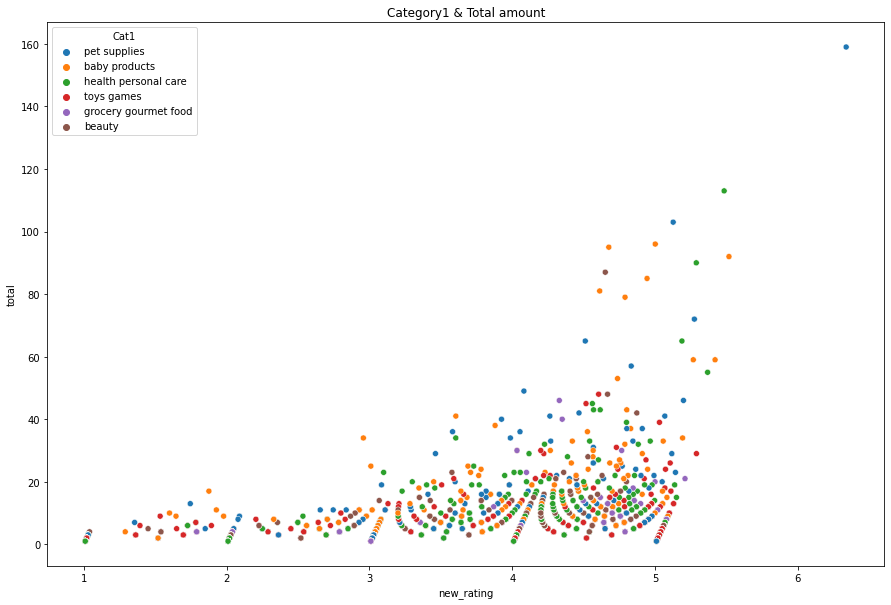

In [14]:
plt.figure(figsize = (15, 10))
plt.title('Category1 & Total amount')
sns.scatterplot(x = 'new_rating', y = 'total', hue = 'Cat1', data = rating_rec)

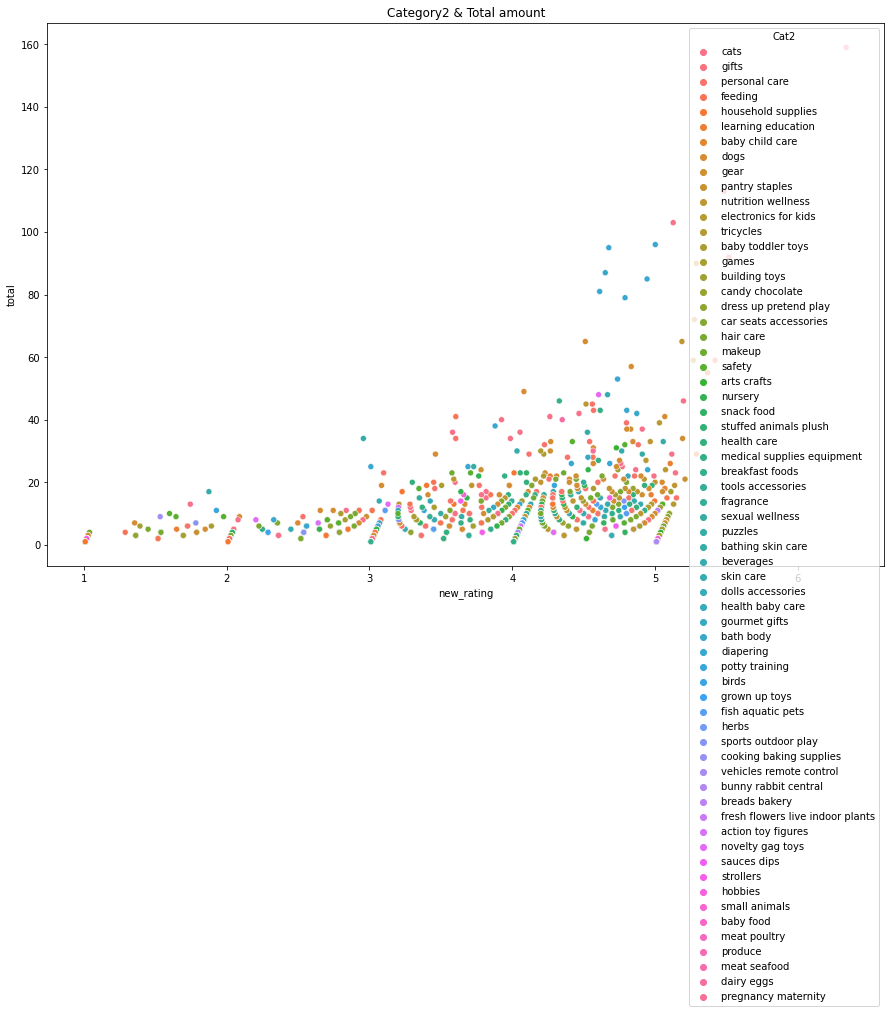

In [15]:
plt.figure(figsize = (15, 10))
plt.title('Category2 & Total amount')
sns.scatterplot(x = 'new_rating', y = 'total', hue = 'Cat2', data = rating_rec)

In [16]:
rating_rec[rating_rec['Cat1'] == 'beauty'][:5]

,Cat1,Cat2,productId,Score,total,new_rating
31,beauty,hair care,B0009V1YRS,5.0,8,5.08
32,beauty,makeup,B000HP276I,5.0,8,5.08
49,beauty,hair care,B000N2LYTQ,5.0,7,5.07
61,beauty,hair care,B0007CXXNC,5.0,7,5.07
69,beauty,tools accessories,B000MIR7TM,5.0,6,5.06


In [21]:
rating_rec[rating_rec['Cat1'] == 'pet supplies'].sort_values('Score', ascending = False)[:5]

,Cat1,Cat2,productId,Score,total,new_rating
6400,pet supplies,dogs,B0000DAIPM,5.0,1,5.01
8077,pet supplies,birds,B000OX2740,5.0,1,5.01
8060,pet supplies,cats,B000HHLK2S,5.0,1,5.01
8055,pet supplies,cats,B0002ARX7Q,5.0,1,5.01
8054,pet supplies,cats,B0009YWE0G,5.0,1,5.01


In [ ]:
def search_rec_cat1(cat1):
    return rating_rec[rating_rec['Cat1'] == cat1][:5]

def search_rec_cat2(cat2):
    return rating_rec[rating_rec['Cat2'] == cat2][:5]

In [ ]:
search_rec_cat1('pet supplies')

,Cat1,Cat2,productId,Score,total,new_rating
0,pet supplies,cats,B000FSFNUE,4.748428,159,6.338428
7,pet supplies,dogs,B000HQHUFA,4.555556,72,5.275556
10,pet supplies,cats,B000PU31MY,4.739130,46,5.199130
14,pet supplies,cats,B000F4W02M,4.913043,23,5.143043
18,pet supplies,cats,B0002DK2DU,4.097087,103,5.127087


In [ ]:
search_rec_cat1('toys games')

,Cat1,Cat2,productId,Score,total,new_rating
5,toys games,learning education,B00008BFZH,5.000000,29,5.290000
16,toys games,electronics for kids,B00005BHK7,5.000000,13,5.130000
17,toys games,tricycles,B00005KBVD,5.000000,13,5.130000
20,toys games,baby toddler toys,B00009YEGL,4.941176,17,5.111176
21,toys games,games,B00000IV34,4.941176,17,5.111176


In [ ]:
search_rec_cat2('makeup')

,Cat1,Cat2,productId,Score,total,new_rating
32,beauty,makeup,B000HP276I,5.0,8,5.08
75,beauty,makeup,B00021CUK0,5.0,6,5.06
191,beauty,makeup,B0001EKYJ2,5.0,4,5.04
214,beauty,makeup,B000B8YYKI,5.0,4,5.04
265,beauty,makeup,B000J1BF3Q,5.0,4,5.04


In [ ]:
search_rec_cat2('cats')

,Cat1,Cat2,productId,Score,total,new_rating
0,pet supplies,cats,B000FSFNUE,4.748428,159,6.338428
10,pet supplies,cats,B000PU31MY,4.739130,46,5.199130
14,pet supplies,cats,B000F4W02M,4.913043,23,5.143043
18,pet supplies,cats,B0002DK2DU,4.097087,103,5.127087
19,pet supplies,cats,B000IYSAIW,4.827586,29,5.117586
